In [1]:
import scvelo as scv
import anndata as ad
import scanpy as sc
import pandas as pd
import mygene

In [2]:
# 1. Load raw counts
#    Assuming `multiome_rna_counts.tsv` has a header row of cell names and the first column as gene names.
counts = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/multiome_rna_counts.tsv", sep='\t', index_col=0)

# 2. Load cell metadata
#    Assuming `multiome_cell_metadata.txt` has rows of cells and columns for metadata,
#    and that one of these columns (likely the index) matches the cell names in `counts.columns`.
cell_metadata = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/multiome_cell_metadata.txt", sep='\t', index_col=0)

In [3]:
# 3. Load spliced and unspliced counts
#    Similar structure to raw counts, with gene names as row index and cell names as column headers.
spliced = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/multiome_spliced_rna_counts.tsv.gz", sep='\t', index_col=0)
unspliced = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/multiome_unspliced_rna_counts.tsv.gz", sep='\t', index_col=0)

In [4]:
# 4. Ensure that cell order and gene order align across all matrices
#    It's crucial that `counts`, `spliced`, and `unspliced` have the same gene index order and cell columns.
#    Also ensure that `cell_metadata`'s index matches the cell column names.
#    If not, you can reorder them. For example:
spliced = spliced[counts.columns]
unspliced = unspliced[counts.columns]
cell_metadata = cell_metadata.loc[counts.columns]

Convert gene names

In [5]:
# Suppose you have a list of ENSG IDs from counts.index
ensg_ids = counts.index.tolist()

# Initialize MyGeneInfo object
mg = mygene.MyGeneInfo()

# Query ensembl gene IDs in batches for efficiency
res = mg.querymany(ensg_ids, scopes='ensemblgene', fields='symbol', species='human')

21 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
974 input query terms found no hit:	['ENSG00000238009', 'ENSG00000230699', 'ENSG00000241180', 'ENSG00000236948', 'ENSG00000271895', 'ENS


In [6]:
# Create a dictionary for ENSG to Symbol mapping
ensembl_to_symbol = {}

# We'll track duplicates if needed
duplicate_count = 0
no_hit_count = 0

for r in res:
    query = r['query']
    if 'notfound' in r:
        # This gene has no hit; skip it
        no_hit_count += 1
        continue
    
    # If we get here, we have at least one symbol
    symbol = r.get('symbol', None)
    if symbol is None:
        # No symbol found, treat as no hit
        no_hit_count += 1
        continue
    
    # Check if we already encountered this ENSG gene
    if query in ensembl_to_symbol:
        # This is a duplicate ENSG. Choose a strategy:
        # For simplicity, we'll just keep the first encountered symbol and ignore the rest.
        duplicate_count += 1
        # Do nothing (keep the previously assigned symbol)
    else:
        ensembl_to_symbol[query] = symbol

print(f"Number of no-hit genes: {no_hit_count}")
print(f"Number of duplicates skipped: {duplicate_count}")


Number of no-hit genes: 7944
Number of duplicates skipped: 25


In [7]:
# Filter your DataFrames to keep only these genes
common_ensgs = [g for g in counts.index if g in ensembl_to_symbol]

In [8]:
counts = counts.loc[common_ensgs]

# Rename the indices to symbols
counts = counts.rename(index=ensembl_to_symbol)

# If you want to ensure uniqueness of gene symbols (some might map to the same symbol),
# you can collapse duplicates by summation:
counts = counts.groupby(counts.index).sum()

In [9]:
print(common_ensgs)
print(counts.shape)
print(counts.index)

['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092', 'ENSG00000284733', 'ENSG00000284662', 'ENSG00000237491', 'ENSG00000177757', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000230368', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000223823', 'ENSG00000205231', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000230415', 'ENSG00000162572', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000272455', 'ENSG00000235098', 'ENSG00000225905', 'ENSG00000205116', 'ENSG00000225285', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG000002

In [10]:
# Find the common set of genes
common_genes = counts.index.intersection(spliced.index).intersection(unspliced.index)
print(common_genes)

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A3GALT2', 'A4GALT',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'hsa-mir-1253'],
      dtype='object', length=22130)


In [11]:
# Subset each DataFrame to the common genes
counts = counts.loc[common_genes]
spliced = spliced.loc[common_genes]
unspliced = unspliced.loc[common_genes]

spliced = spliced.groupby(spliced.index).sum()
unspliced = unspliced.groupby(unspliced.index).sum()

In [12]:
print(counts.shape)
print(spliced.shape)
print(unspliced.shape)

(22130, 8981)
(22130, 8981)
(22130, 8981)


In [13]:
# 5. Create the AnnData object
adata = ad.AnnData(
    X=counts.T.values,
    obs=cell_metadata,
    var=pd.DataFrame(index=counts.index)  # var is for gene metadata; here just set the index.
)

In [14]:
# 6. Add layers for spliced and unspliced counts
adata.layers["spliced"] = spliced.T.values
adata.layers["unspliced"] = unspliced.T.values

In [15]:
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype('category')

In [16]:
# Read the cluster names file
cluster_df = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/multiome_cluster_names.txt", sep='\t')

# Create a dictionary mapping Cluster.ID (e.g. c0) to Cluster.Name (e.g. nIPC/GluN1)
cluster_map = dict(zip(cluster_df['Cluster.ID'], cluster_df['Cluster.Name']))

# Now map these to a new column in adata.obs
adata.obs['cluster_name'] = adata.obs['seurat_clusters'].map(cluster_map)

In [17]:
adata

AnnData object with n_obs × n_vars = 8981 × 22130
    obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'CR_ATAC.Confidently.mapped.read.pairs', 'CR_ATAC.Fraction.of.genome.in.peaks', 'CR_ATAC.Fraction.of.high.quality.fragments.in.cells', 'CR_ATAC.Fraction.of.high.quality.fragments.overlapping.TSS', 'CR_ATAC.Fraction.of.high.quality.fragments.overlapping.peaks', 'CR_ATAC.Fraction.of.transposition.events.in.peaks.in.cells', 'CR_ATAC.Mean.raw.read.pairs.per.cell', 'CR_ATAC.Median.high.quality.fragments.per.cell', 'CR_ATAC.Non.nuclear.read.pairs', 'CR_ATAC.Number.of.peaks', 'CR_ATAC.Percent.duplicates', 'CR_ATAC.Q30.bases.in.barcode', 'CR_ATAC.Q30.bases.in.read.1', 'CR_ATAC.Q30.bases.in.read.2', 'CR_ATAC.Q30.bases.in.sample.index.i1', 'CR_ATAC.Sequenced.read.pairs', 'CR_ATAC.TSS.enrichment.score', 'CR_ATAC.Unmapped.read.pairs', 'CR_ATAC.Valid.barcodes', 'CR_Feature.li

In [18]:
# Define the cluster names you want to remove
clusters_to_remove = ["IN1", "IN2", "IN3", "IN4", "SP", "mGPC/OPC"]

# Create a boolean mask that is True for cells NOT in the clusters_to_remove
mask = ~adata.obs['cluster_name'].isin(clusters_to_remove)

# Subset the AnnData object
adata = adata[mask].copy()

In [ ]:
adata.write("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/Writeup13_greenleaf_multiome_processed.h5ad")

Start scVelo

In [20]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

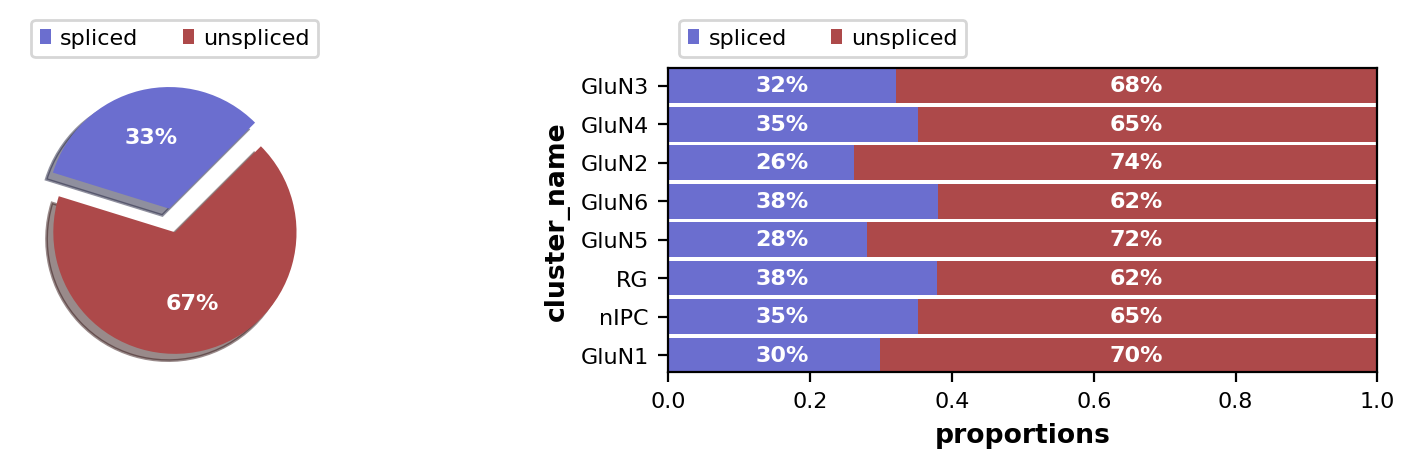

In [21]:
scv.pl.proportions(adata, groupby = 'cluster_name')

In [22]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 14073 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_2335569/3334712381.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0

computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [23]:
adata

AnnData object with n_obs × n_vars = 6748 × 2000
    obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'CR_ATAC.Confidently.mapped.read.pairs', 'CR_ATAC.Fraction.of.genome.in.peaks', 'CR_ATAC.Fraction.of.high.quality.fragments.in.cells', 'CR_ATAC.Fraction.of.high.quality.fragments.overlapping.TSS', 'CR_ATAC.Fraction.of.high.quality.fragments.overlapping.peaks', 'CR_ATAC.Fraction.of.transposition.events.in.peaks.in.cells', 'CR_ATAC.Mean.raw.read.pairs.per.cell', 'CR_ATAC.Median.high.quality.fragments.per.cell', 'CR_ATAC.Non.nuclear.read.pairs', 'CR_ATAC.Number.of.peaks', 'CR_ATAC.Percent.duplicates', 'CR_ATAC.Q30.bases.in.barcode', 'CR_ATAC.Q30.bases.in.read.1', 'CR_ATAC.Q30.bases.in.read.2', 'CR_ATAC.Q30.bases.in.sample.index.i1', 'CR_ATAC.Sequenced.read.pairs', 'CR_ATAC.TSS.enrichment.score', 'CR_ATAC.Unmapped.read.pairs', 'CR_ATAC.Valid.barcodes', 'CR_Feature.lin

In [24]:
sc.tl.pca(adata)

In [25]:
sc.tl.umap(adata)

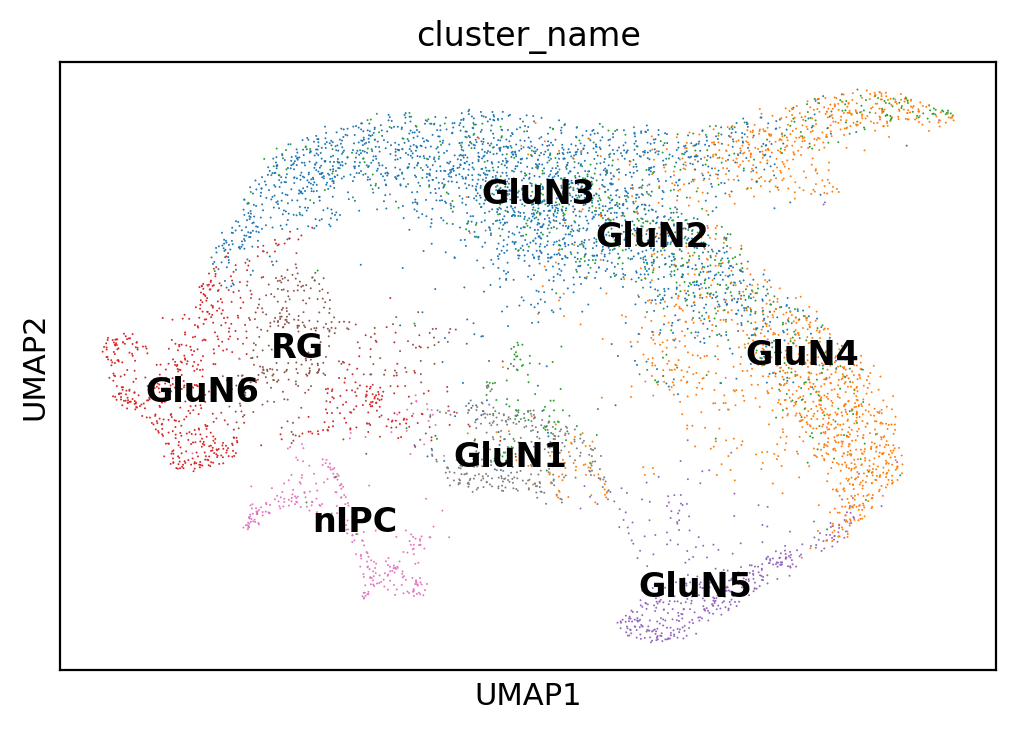

In [26]:
sc.pl.umap(
    adata,
    color="cluster_name",
    # Setting a smaller point size to get prevent overlap
    size=2,
    legend_loc="on data"
)

In [27]:
scv.tl.velocity(adata)

computing velocities


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [28]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


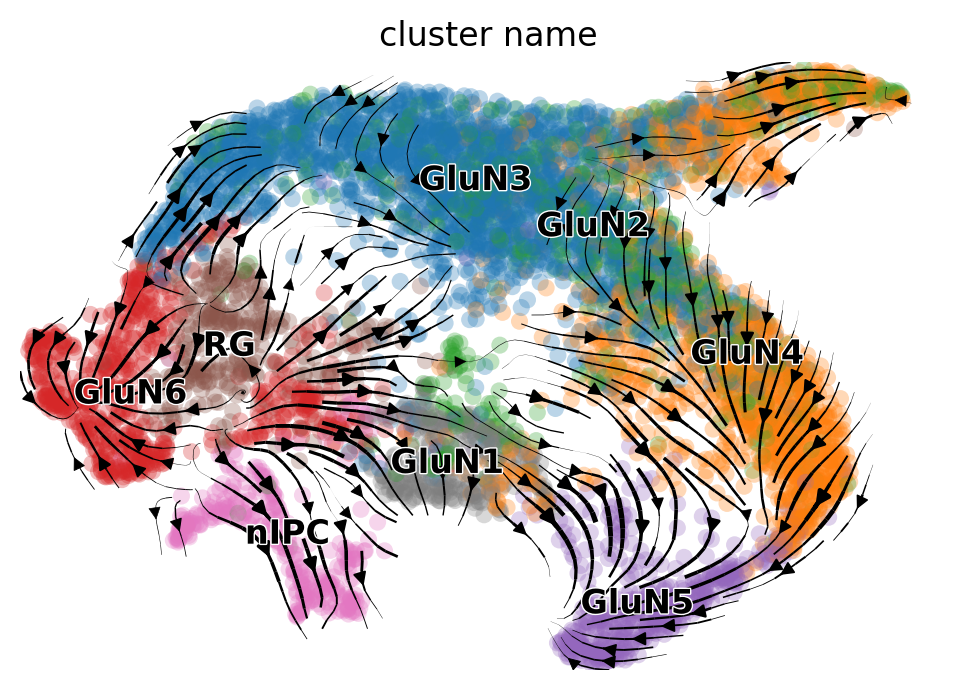

In [30]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='cluster_name')